## **Домашняя работа 1.** (до 5 ноября)
### Описание задания:
Изучаем графовые *языковые модели*, построенные на основе совместной встречаемости слов. Это исследовательская работы, которая требует от вас как применения методов, которые мы изучали, так и качественного и количественного анализа результатов. Вы столкнетесь с вычислительными проблемами, если будете использовать методы, не думаю о том, какова их алгоритмическая сложность.  Далее будет описан примерный пул вопросов, на которые я ожидаю от вас ответов. Будьте уверены, ваша инициатива в исследовании будет оценена.    

# Обработка текста

In [303]:
import nltk
nltk.download('wordnet')
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
import networkx as nx
from typing import List
import matplotlib.pyplot as plt
from pymystem3 import Mystem as mystem
from collections import Counter
import math
import numpy as np
import matplotlib.colors as mcolors
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [304]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Даннные для посторения графа уже здесь. Прежде всего я предлагаю их почистить от пунктуации и лемматизировать, чтобы получить более точную картинку мира.


In [305]:
original_sentences = brown.sents()[:7]

In [306]:
def text_processing(sentences:List[List[str]]):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in sentences]
    lower_sent = [[word.lower() for word in sentence] for sentence in lemmatized_words]
    clean_sent = [[re.sub(r'[^A-Za-z0-9]+', '', word) for word in sentence] for sentence in lower_sent]
    final_sent = [[word for word in sentence if word] for sentence in clean_sent]
    return final_sent

In [307]:
sentences = text_processing(original_sentences)

Теперь создадим функцию, которая наши очищеннные от всего лишнего предложения преобразовывает в пары и в граф. Замечу, что внутри функции есть несколько флагов, которые можно менять и от которых зависит, будет граф направленным или нет и будут ли в окно попадать слова только следующие, или же предыдущие тоже.


In [308]:
def create_lm_coocurance(sentences:List[List[str]], window_size, 
                         both_sided_window=False, make_directed_graph=True):
    """
    :window_size: размер окна
    :both_sided_window: флаг, показывающий, смотрим мы на окно с двух сторон от каждого слова
    :make_directed_graph: флаг, обозначающий, делаем мы граф направленным или же нет
    """
    pairs = []
    for sent in sentences:
        for index, word in enumerate(sent):
            for next_index in range(index+1, min(index+window_size+1, len(sent))):
                pair = (word, sent[next_index])
                pairs.append(pair)  
                if both_sided_window:
                    pair = (sent[next_index], word)
                    pairs.append(pair) 
    graph = (nx.DiGraph(pairs) if make_directed_graph else nx.Graph(pairs))
    
    return graph, pairs   

In [309]:
def visualize_graph(graph):
    nx.kamada_kawai_layout(graph) 
    pos = nx.kamada_kawai_layout(graph)
    plt.figure(figsize=(12, 10))
    nx.draw(graph, pos, with_labels=True, node_color='#009999')

In [310]:
graph, pairs = create_lm_coocurance(sentences, 3, 
                                    both_sided_window=False, 
                                    make_directed_graph=False)

Вот к примеру визуализация графа с окном равным 3. Он ненаправленный, невзешенный и слова берутся только с одной стороны.

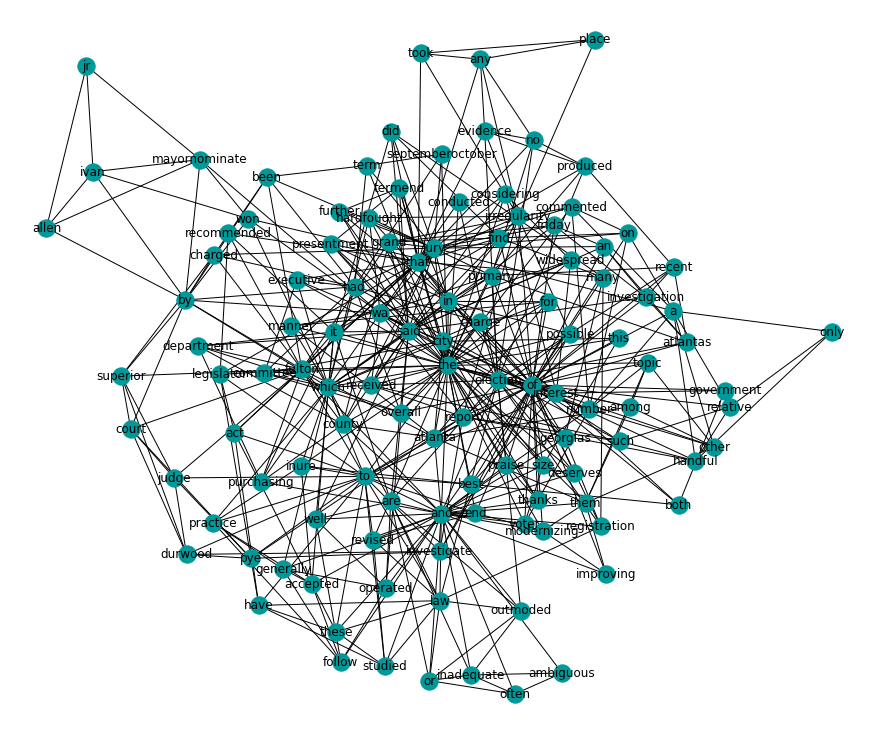

In [311]:
visualize_graph(graph)


# Descriptive analysis
### Задание 1:
Посмотрите сколько компонент, вершин, ребер. Если компонент несколько, не забывайте при анализе это учитывать. Плотность. Средняя степень вершины в графе. (2 points)

In [312]:
'''Посчитаем разные метрики'''
from networkx import density 
print('Number of nodes:', nx.number_of_nodes(graph))
print('Number of edges:', nx.number_of_edges(graph))
print('Number of components:', nx.number_connected_components(graph))
print('The density of graph is:', nx.density(graph))
print('The average degree of graph is:', len(graph.edges())/len(graph.nodes()))

Number of nodes: 116
Number of edges: 492
Number of components: 1
The density of graph is: 0.07376311844077961
The average degree of graph is: 4.241379310344827


У нас в графе довольно много узлов и ребер, при этом кажется, что плотность не очень высокая (но опять же, я не могу судить, потому что мне не с чем сравнивать).

 ### Задание 2:
*   Расcчитайте распределние степеней вершин внутри графа и постройте график (1 point)


*   Сделайте log-log scale для этих значений (1 point) 


*   Проверьте, если здесь powerlaw distribution (1 point) (то есть постройте апроксимирующую прямую) Дайте анализ результатам с учетом того, что ваш граф не является scale-free network 

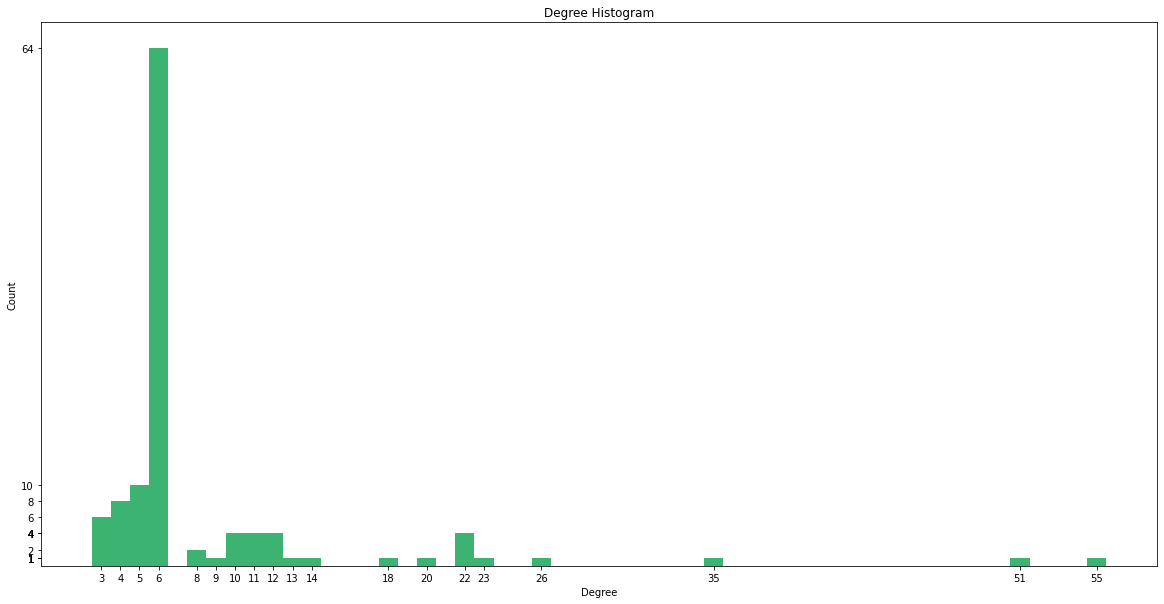

In [313]:
'''Распределение вершин внутри графа'''
degree_sequence = sorted([degree for node, degree in graph.degree()], reverse=True)  # degree sequence
degree_count = Counter(degree_sequence)
degree, count = zip(*degree_count.items())

fig, ax = plt.subplots(figsize=(20,10))
plt.bar(degree, count, width=1, color="mediumseagreen")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks(degree)
ax.set_yticks(count)
plt.show()

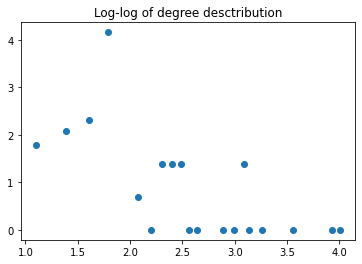

In [314]:
'''log-log scale для распределения вершин'''
plt.title("Log-log of degree desctribution")
plt.scatter([math.log(i) for i in degree_count.keys()], [math.log(i) for i in degree_count.values()])
plt.show()

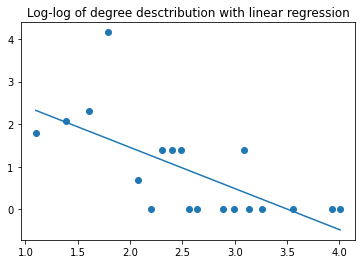

m равно: -0.9656508518637265


In [315]:
'''апросимирующая прямая'''
x = np.array([math.log(i) for i in degree_count.keys()])
y = np.array([math.log(i) for i in degree_count.values()])
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, m*x + b)
plt.title("Log-log of degree desctribution with linear regression")
plt.show()

print('m равно:', m)

**ИНТЕРПРЕТАЦИЯ**: Как видно из гистограммы распределения вершин, вершин, которые имеют связь еще с 6-ю нодами, наибольшее количество. При взятии логарифма от x и от y и построении логарифмической прямой, мы видим следующую апроксимацию: количество вершин с высокой степенью убывает примерно по закону Ципфа (1/x), поскольку m примерно равно -1.


### Задание 3:
Используйте ваши знания о центральностях и об их применимости к тем или иным типам графов. Рассчитайте их (возможно на сабграфе), сделайте отображение графа, на котором размер вершины будет зависить от показателя центральности, ну или цветом.
(3 points)

In [316]:
'''Подсчет показателей разных центральностей и выведелние результатов в датафрейме'''
degree = nx.degree_centrality(graph)
closeness = nx.closeness_centrality(graph)
eigenvector = nx.eigenvector_centrality(graph)
betweenness = nx.betweenness_centrality(graph)
df = pd.DataFrame([degree, closeness, eigenvector, betweenness], index=['degree','closeness', 'eigenvector', 'betweenness']).T
df

,degree,closeness,eigenvector,betweenness
the,0.478261,0.635359,0.415256,0.234449
fulton,0.173913,0.518018,0.134443,0.078029
county,0.086957,0.469388,0.110153,0.004274
grand,0.069565,0.437262,0.079734,0.002558
jury,0.191304,0.481172,0.148100,0.039385
...,...,...,...,...
practice,0.052174,0.387205,0.036730,0.002058
inure,0.052174,0.430712,0.064703,0.002403
best,0.052174,0.445736,0.079899,0.002010
both,0.034783,0.389831,0.040327,0.000073


In [317]:
'''Функция для визуализации графа согласно показателю какой-нибудь центральности'''
def draw(G, pos, measures, measure_name):
    
    fig = plt.figure(figsize=(20,15))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.cm.RdBu, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    # nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G, pos, font_color='white', font_size='11')
    edges = nx.draw_networkx_edges(G, pos, edge_color = 'dimgrey')

    plt.title(measure_name, color='white', size = '16', weight = 'bold')
    plt.colorbar(nodes, orientation = 'horizontal')
    plt.axis('off')
    fig.set_facecolor('black')
    plt.show()

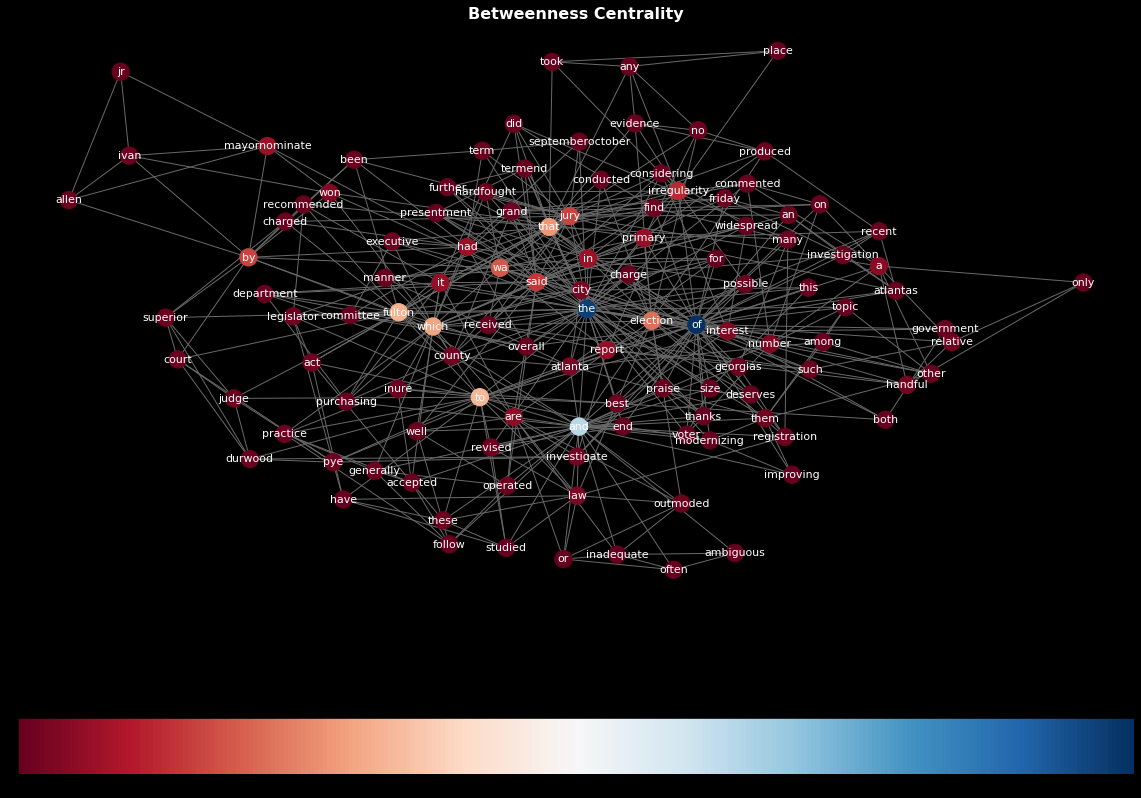

In [318]:
pos = nx.kamada_kawai_layout(graph)
draw(graph, pos, nx.betweenness_centrality(graph),'Betweenness Centrality')

**ИНТЕРПРЕТАЦИЯ**: 
Как видно, наивысшее значение Betweenness centrality у таких слов, как the, of, and, to и which. На мой взгляд, это не удивительно, учитывая, что слова все-таки служебные (союзы/предлоги) и что мы не могли убрать их из текста, внеся в список стоп-слов. Они должны были стать выбросами, учитывая, что они всегда 'прикреплены' к глаголу или существительному. Именно поэтому через них проходит наибольшее число кратчайших путей.

# Поиск сообществ

### Задание 4:
Применить методы поиска сообществ и попытаться интерпретировать выдачу (3 points)

Посмотри на критерий **Гирвана-Ньюмана** (который уже предлагался в задании). Визуализировать не будем, поскольку действительно результат выходит страннным и не показательным.

In [319]:
import networkx.algorithms.community as nxcom
result = nxcom.girvan_newman(graph)
communities = next(result)
len(communities)

2

Применим для выделения сообществ  **Louvain method** и визуализируем согласно параметру **Modularity**:

Количество сообществ: 7
Показатель моделярности: 0.41944485755833166


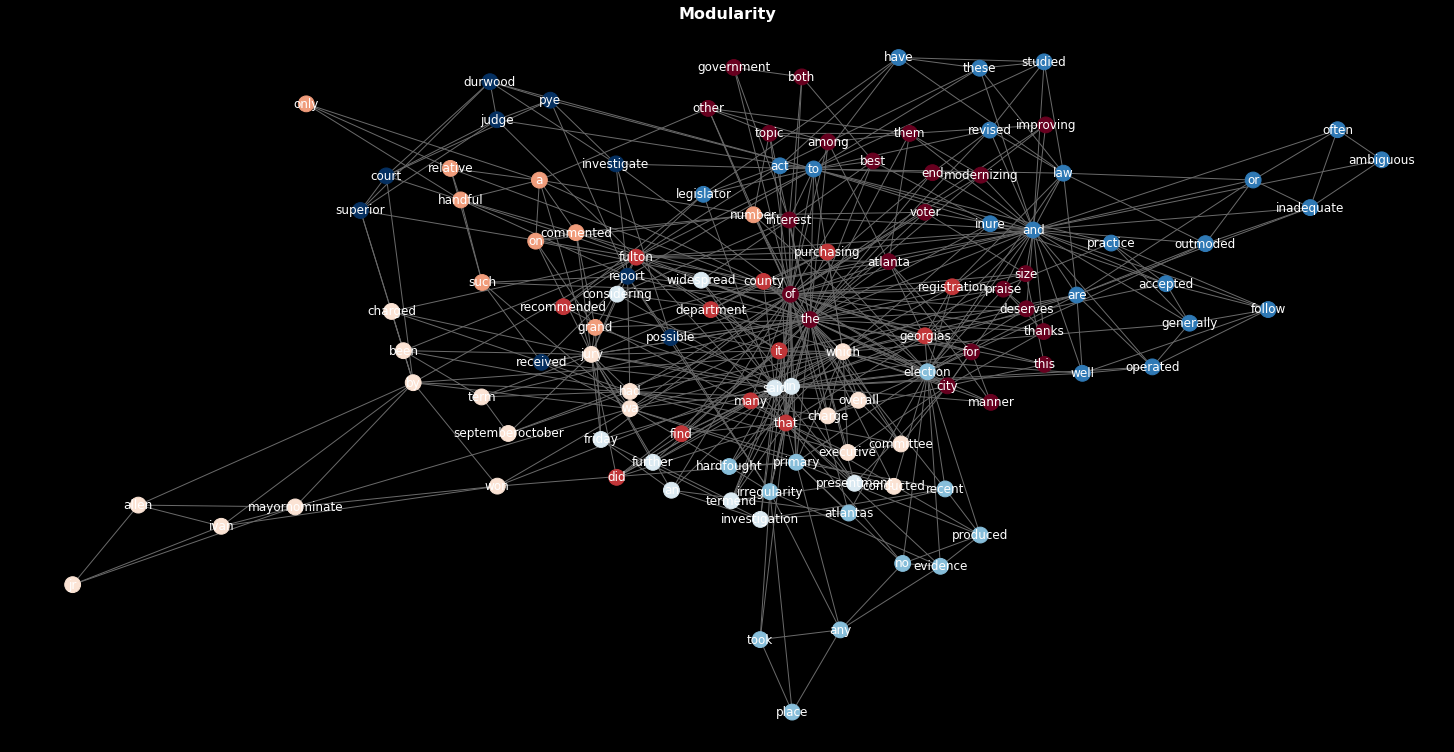

In [324]:
import community as louvain_community
partition = louvain_community.best_partition(graph)
modularity = louvain_community.modularity(partition, graph)

print('Количество сообществ:', max(Counter(partition).values()))
print('Показатель моделярности:', modularity)

fig = plt.figure(figsize = (20,10))
values = [partition.get(node) for node in graph.nodes()]
nx.draw_spring(graph, cmap=plt.cm.RdBu, node_color = values, node_size=250, with_labels=True, font_color = 'white', edge_color = 'dimgray')
plt.title('Modularity', size = '16', weight = 'bold', color = 'white')
fig.set_facecolor('black')
plt.show()

**ИНТЕРПРЕТАЦИЯ**: Показатель модулярности довольно высокий (хотя тоже вопрос - относительно чего). На визуализации видно, что вообще сообщества выделились неплохо (особенно хорошее разделение получилось справа внизу и наверху и слева, п центру все чуть-чуть вперемежку). Учитывая, что выделилось от 5 до 7 сообществ, а предложений у нас 7, есть смысл проверить, попали ли слова из одного предложения в одно сообщество. При сравнении с текстом Брауна видно, что некоторые слова, попавшие в один кластер, действительно появляются в одном предложении (и иногда больше нигде).

#Подарок для вас со стак оферфлоу: 
отрисовка графовой кластеризации с помощью дендрограммы (работает только с выходом из функции girvan_newman)

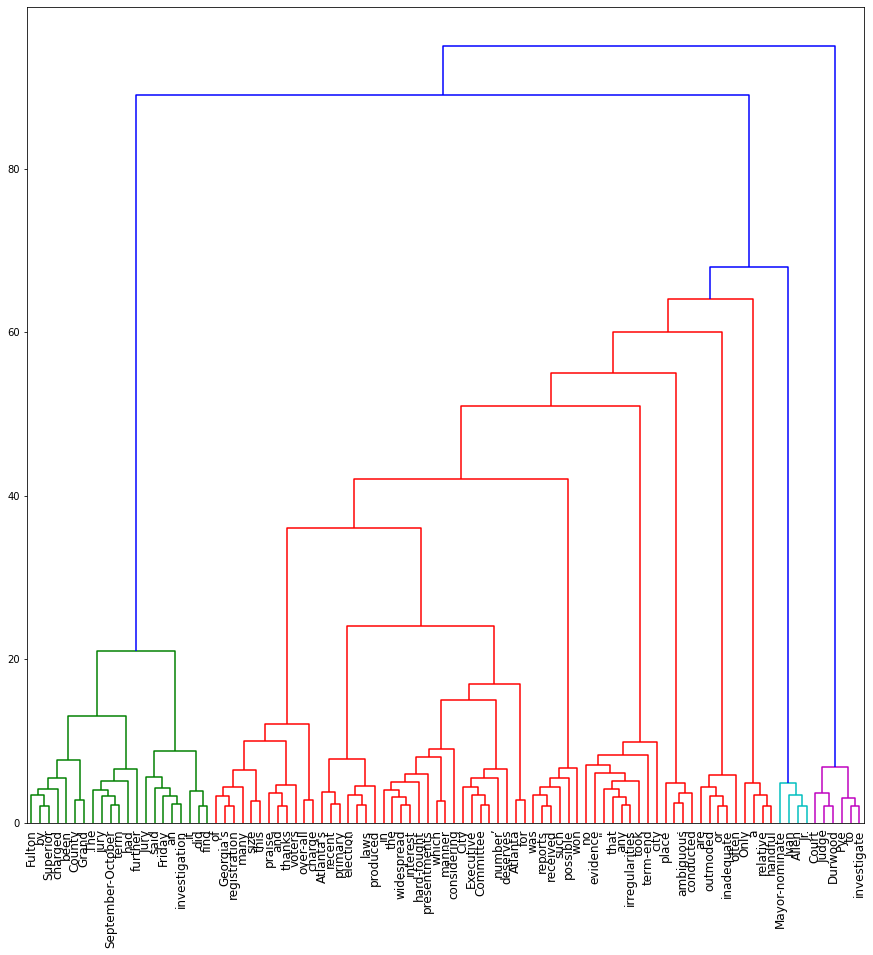

In [ ]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from networkx.algorithms.community.centrality import subset_rank_dict

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub, node_labels, subset_rank_dict):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

def plot_dendrogram(G, method_to_find_community = girvan_newman):
  communities = list(method_to_find_community(G))
  # building initial dict of node_id to each possible subset:
  node_id = 0
  init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
  for comm in communities:
      for subset in list(comm):
          if subset not in init_node2community_dict.values():
              node_id += 1
              init_node2community_dict[node_id] = subset

  # turning this dictionary to the desired format in @mdml's answer
  node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
  for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
      for node_id_parent, group in init_node2community_dict.items():
          if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
              node_id_to_children[node_id_parent].append(node_id1)
              node_id_to_children[node_id_parent].append(node_id2)

  # also recording node_labels dict for the correct label for dendrogram leaves
  node_labels = dict()
  for node_id, group in init_node2community_dict.items():
      if len(group) == 1:
          node_labels[node_id] = list(group)[0]
      else:
          node_labels[node_id] = ''

  # also needing a subset to rank dict to later know within all k-length merges which came first
  subset_rank_dict = dict()
  rank = 0
  for e in communities[::-1]:
      for p in list(e):
          if tuple(p) not in subset_rank_dict:
              subset_rank_dict[tuple(sorted(p))] = rank
              rank += 1
  subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

  # finally using @mdml's magic, slightly modified:
  G           = nx.DiGraph(node_id_to_children)
  nodes       = G.nodes()
  leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
  inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

  # Compute the size of each subtree
  subtree = dict( (n, [n]) for n in leaves )
  for u in inner_nodes:
      children = set()
      node_list = list(node_id_to_children[u])
      while len(node_list) > 0:
          v = node_list.pop(0)
          children.add( v )
          node_list += node_id_to_children[v]
      subtree[u] = sorted(children & leaves)

  inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

  # Construct the linkage matrix
  leaves = sorted(leaves)
  index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
  Z = []
  k = len(leaves)
  for i, n in enumerate(inner_nodes):
      children = node_id_to_children[n]
      x = children[0]
      for y in children[1:]:
          z = tuple(sorted(subtree[x] + subtree[y]))
          i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
          Z.append([i, j, get_merge_height(subtree[n], node_labels, subset_rank_dict), len(z)]) # <-- float is required by the dendrogram function
          index[z] = k
          subtree[z] = list(z)
          x = z
          k += 1

  plt.figure(figsize=(15, 15))
  dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
  plt.xticks(fontsize=12)
  plt.show()#

plot_dendrogram(g)

Можете применить при подготовке корпуса любые другие фишки, котоыре вы умеете использовать, как то снятие частеречной омонимии и прочее. Инициатива поощряется, без нее 10 не поставлю :)